# Model Explanation and Interpretability Analysis

This notebook provides comprehensive interpretability analysis for the CatBoost CTR prediction model using SHAP (SHapley Additive exPlanations) values.

## Overview
- Load trained CatBoost model and test data
- Generate SHAP values for feature importance analysis
- Create global feature importance visualizations
- Analyze prediction patterns across different outcome categories:
  - True Positives
  - True Negatives
  - False Positives
  - False Negatives
- Provide individual prediction explanations using waterfall plots

## Import Libraries and Setup

In [1]:
from catboost import CatBoostClassifier, EFstrType
import shap
import pandas as pd
from test_case_fairmoney.utils.constants import PATH_DATA_COMPRESSED, PATH_MODELS
from catboost import (
    CatBoostClassifier,
    Pool,
)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 800)
import warnings

warnings.filterwarnings("ignore")

## Load Data

Load the preprocessed datasets. We'll use a subset of the test data for SHAP analysis to ensure reasonable computation time.

In [2]:
# Load original datasets for CatBoost
df_train = pd.read_parquet(PATH_DATA_COMPRESSED / "df_train.parquet")
df_val = pd.read_parquet(PATH_DATA_COMPRESSED / "df_val.parquet")
df_test = pd.read_parquet(PATH_DATA_COMPRESSED / "df_test.parquet")

## Model Configuration

Define the features and parameters used by the CatBoost model.

In [3]:
# Features for CatBoost (original categorical features)
feat_num_cat = ["checking_balance", "amount", "savings_balance", "employment_months"]
feat_cat_cat = [
    "credit_history",
    "personal_status",
    "property",
    "installment_plan",
    "is_checking_negative",
]
target = "default"
threshold = 0.47  # Optimized threshold from previous analysis

print(
    f"Features for analysis ({len(feat_cat_cat) + len(feat_num_cat)}): {feat_cat_cat + feat_num_cat}"
)
print(f"Classification threshold: {threshold}")

for feature in feat_cat_cat:
    df_train[feature] = df_train[feature].fillna("Missing")
    df_val[feature] = df_val[feature].fillna("Missing")
    df_test[feature] = df_test[feature].fillna("Missing")

Features for analysis (9): ['credit_history', 'personal_status', 'property', 'installment_plan', 'is_checking_negative', 'checking_balance', 'amount', 'savings_balance', 'employment_months']
Classification threshold: 0.47


## Prepare CatBoost Data Pools

In [4]:
# Create CatBoost Pool objects
train_pool = Pool(
    data=df_train[feat_cat_cat + feat_num_cat],
    label=df_train[target],
    cat_features=feat_cat_cat,
)
test_pool = Pool(
    data=df_test[feat_cat_cat + feat_num_cat],
    label=df_test[target],
    cat_features=feat_cat_cat,
)
val_pool = Pool(
    data=df_val[feat_cat_cat + feat_num_cat],
    label=df_val[target],
    cat_features=feat_cat_cat,
)

print("✅ CatBoost Pool objects created successfully")

✅ CatBoost Pool objects created successfully


## Load Trained Model and Generate Predictions

In [5]:
# Load the pre-trained optimized CatBoost model
model_cb = CatBoostClassifier()
model_cb.load_model(PATH_MODELS / "catboost_optimized.cbm")
print("✅ CatBoost model loaded successfully")

✅ CatBoost model loaded successfully


In [6]:
# Generate predictions and classifications
df_test["pred"] = model_cb.predict_proba(test_pool)[:, 1]
df_test["y_pred"] = (df_test["pred"] >= threshold).astype(int)

print("✅ Predictions generated")
print(
    f"Prediction probability range: [{df_test['pred'].min():.3f}, {df_test['pred'].max():.3f}]"
)
print(
    f"Predicted defaults: {df_test['y_pred'].sum():,} / {len(df_test):,} ({df_test['y_pred'].mean():.1%})"
)
print("\nSample predictions:")
print(df_test[["default", "pred", "y_pred"]].head())

✅ Predictions generated
Prediction probability range: [0.445, 0.548]
Predicted defaults: 147 / 200 (73.5%)

Sample predictions:
   default      pred  y_pred
0        0  0.490345       1
1        0  0.509374       1
2        1  0.518251       1
3        0  0.541882       1
4        1  0.498651       1


## SHAP Analysis Setup

Calculate SHAP values for model interpretability. SHAP values explain how each feature contributes to individual predictions.

In [7]:
# Calculate SHAP values using CatBoost's built-in method
print("Computing SHAP values... (this may take a few minutes)")
shap_values = model_cb.get_feature_importance(test_pool, type=EFstrType.ShapValues)

# Create SHAP explainer object
explainer = shap.Explainer(model_cb)

# Extract expected value and feature SHAP values
expected_value = shap_values[0, -1]  # Last column contains expected value
shap_values = shap_values[:, :-1]  # Remove expected value column

print(
    f"✅ SHAP values computed for {shap_values.shape[0]:,} samples and {shap_values.shape[1]} features"
)
print(f"Model expected value (baseline): {expected_value:.4f}")

Computing SHAP values... (this may take a few minutes)
✅ SHAP values computed for 200 samples and 9 features
Model expected value (baseline): -0.0310


## Global Feature Importance

### Feature Importance Bar Plot

Show the overall importance of each feature across all predictions.

In [8]:
print("=== Global Feature Importance ===")
plt.title("Feature Importance (Mean |SHAP Value|)")
shap.summary_plot(shap_values, df_test[feat_cat_cat + feat_num_cat])

=== Global Feature Importance ===


#### Comments:
The SHAP global feature importance plots validate our EDA findings. The numerical features show consistent patterns between the SHAP analysis and the exploratory analysis, confirming the robustness of the identified relationships with the target variable.

## Feature Dependence Analysis

### Individual Feature Dependence Plots

Analyze how each feature's values relate to its impact on predictions.

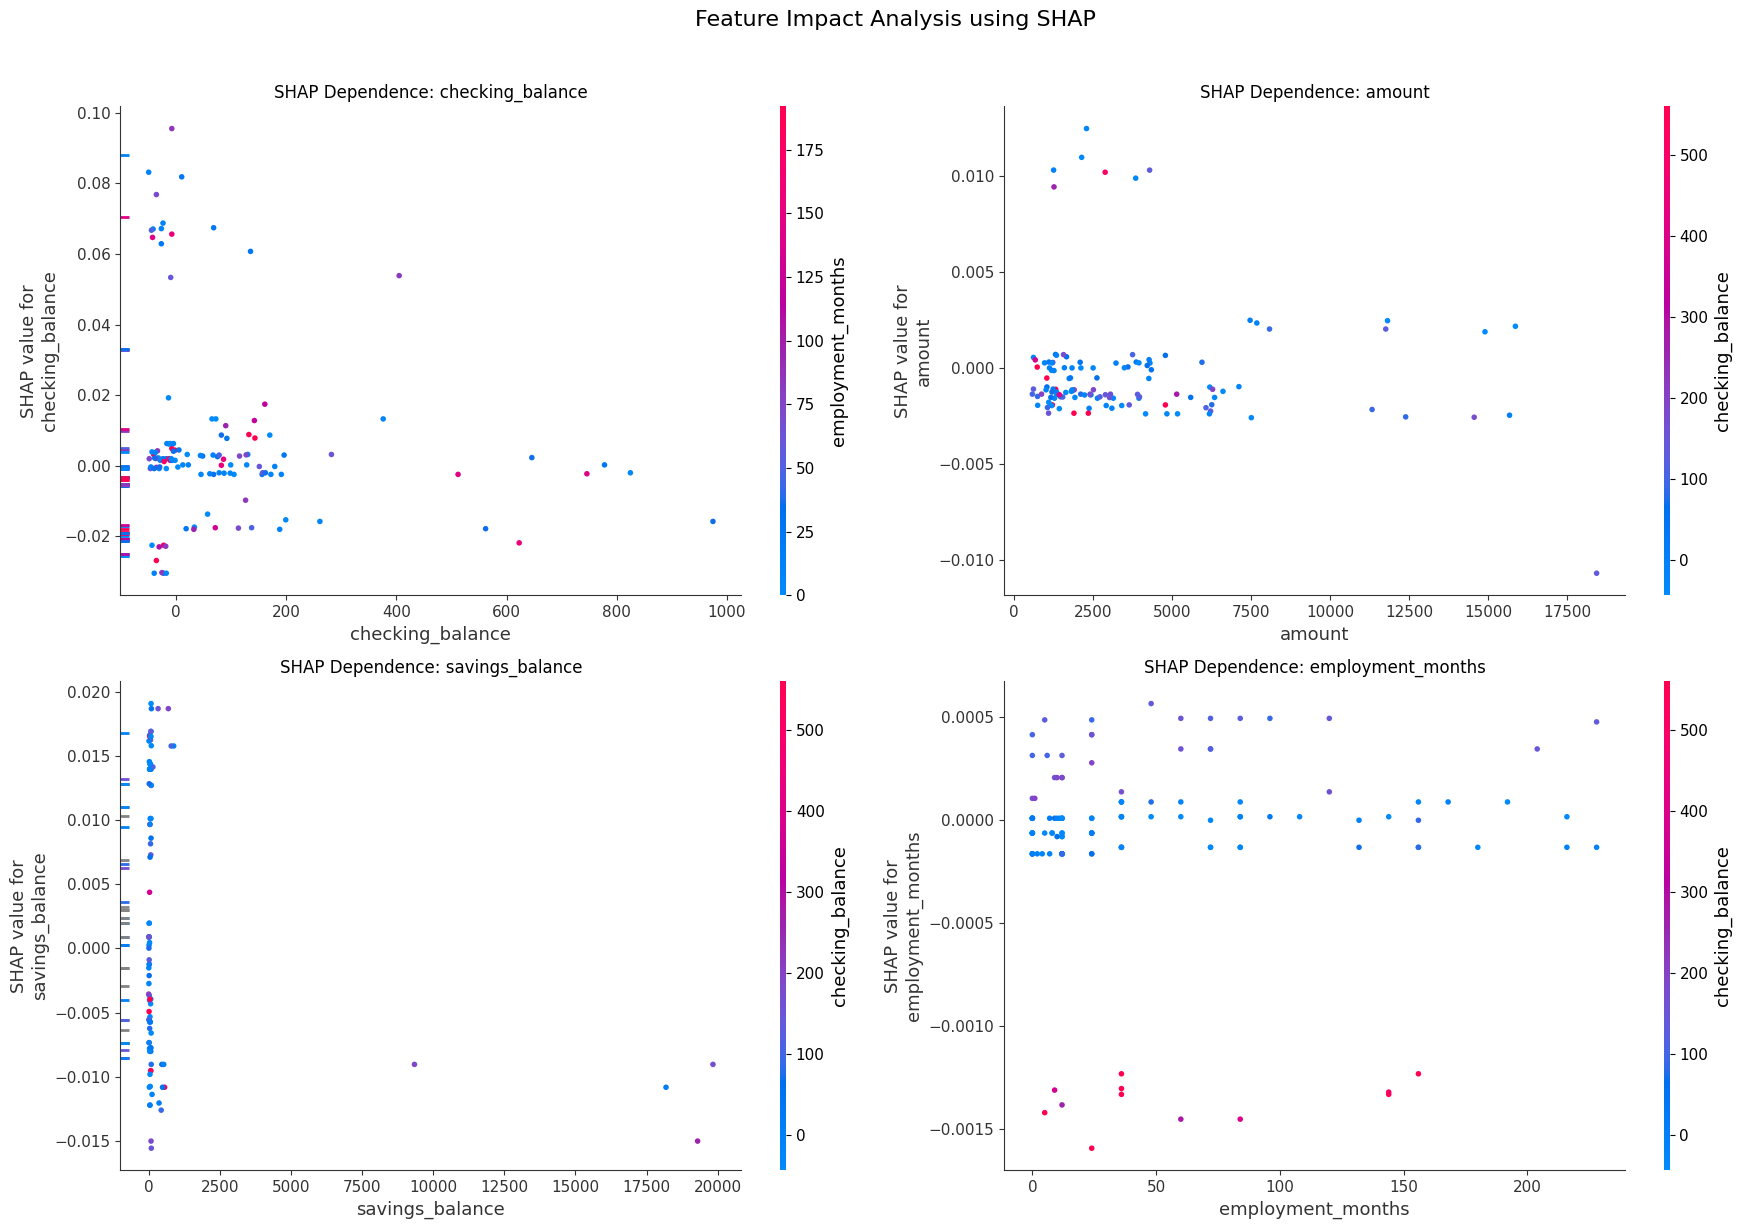

In [9]:
shap_values_subset = shap_values[:, : len(feat_num_cat)]
from test_case_fairmoney.utils.explainability import plot_shap_dependence_grid

plot_shap_dependence_grid(
    feature_list=feat_num_cat,
    shap_values=shap_values_subset,
    X_test=df_test[feat_num_cat],
    feature_names=feat_num_cat,
)

#### Comments:
SHAP global plots confirm the numerical feature patterns identified in EDA.

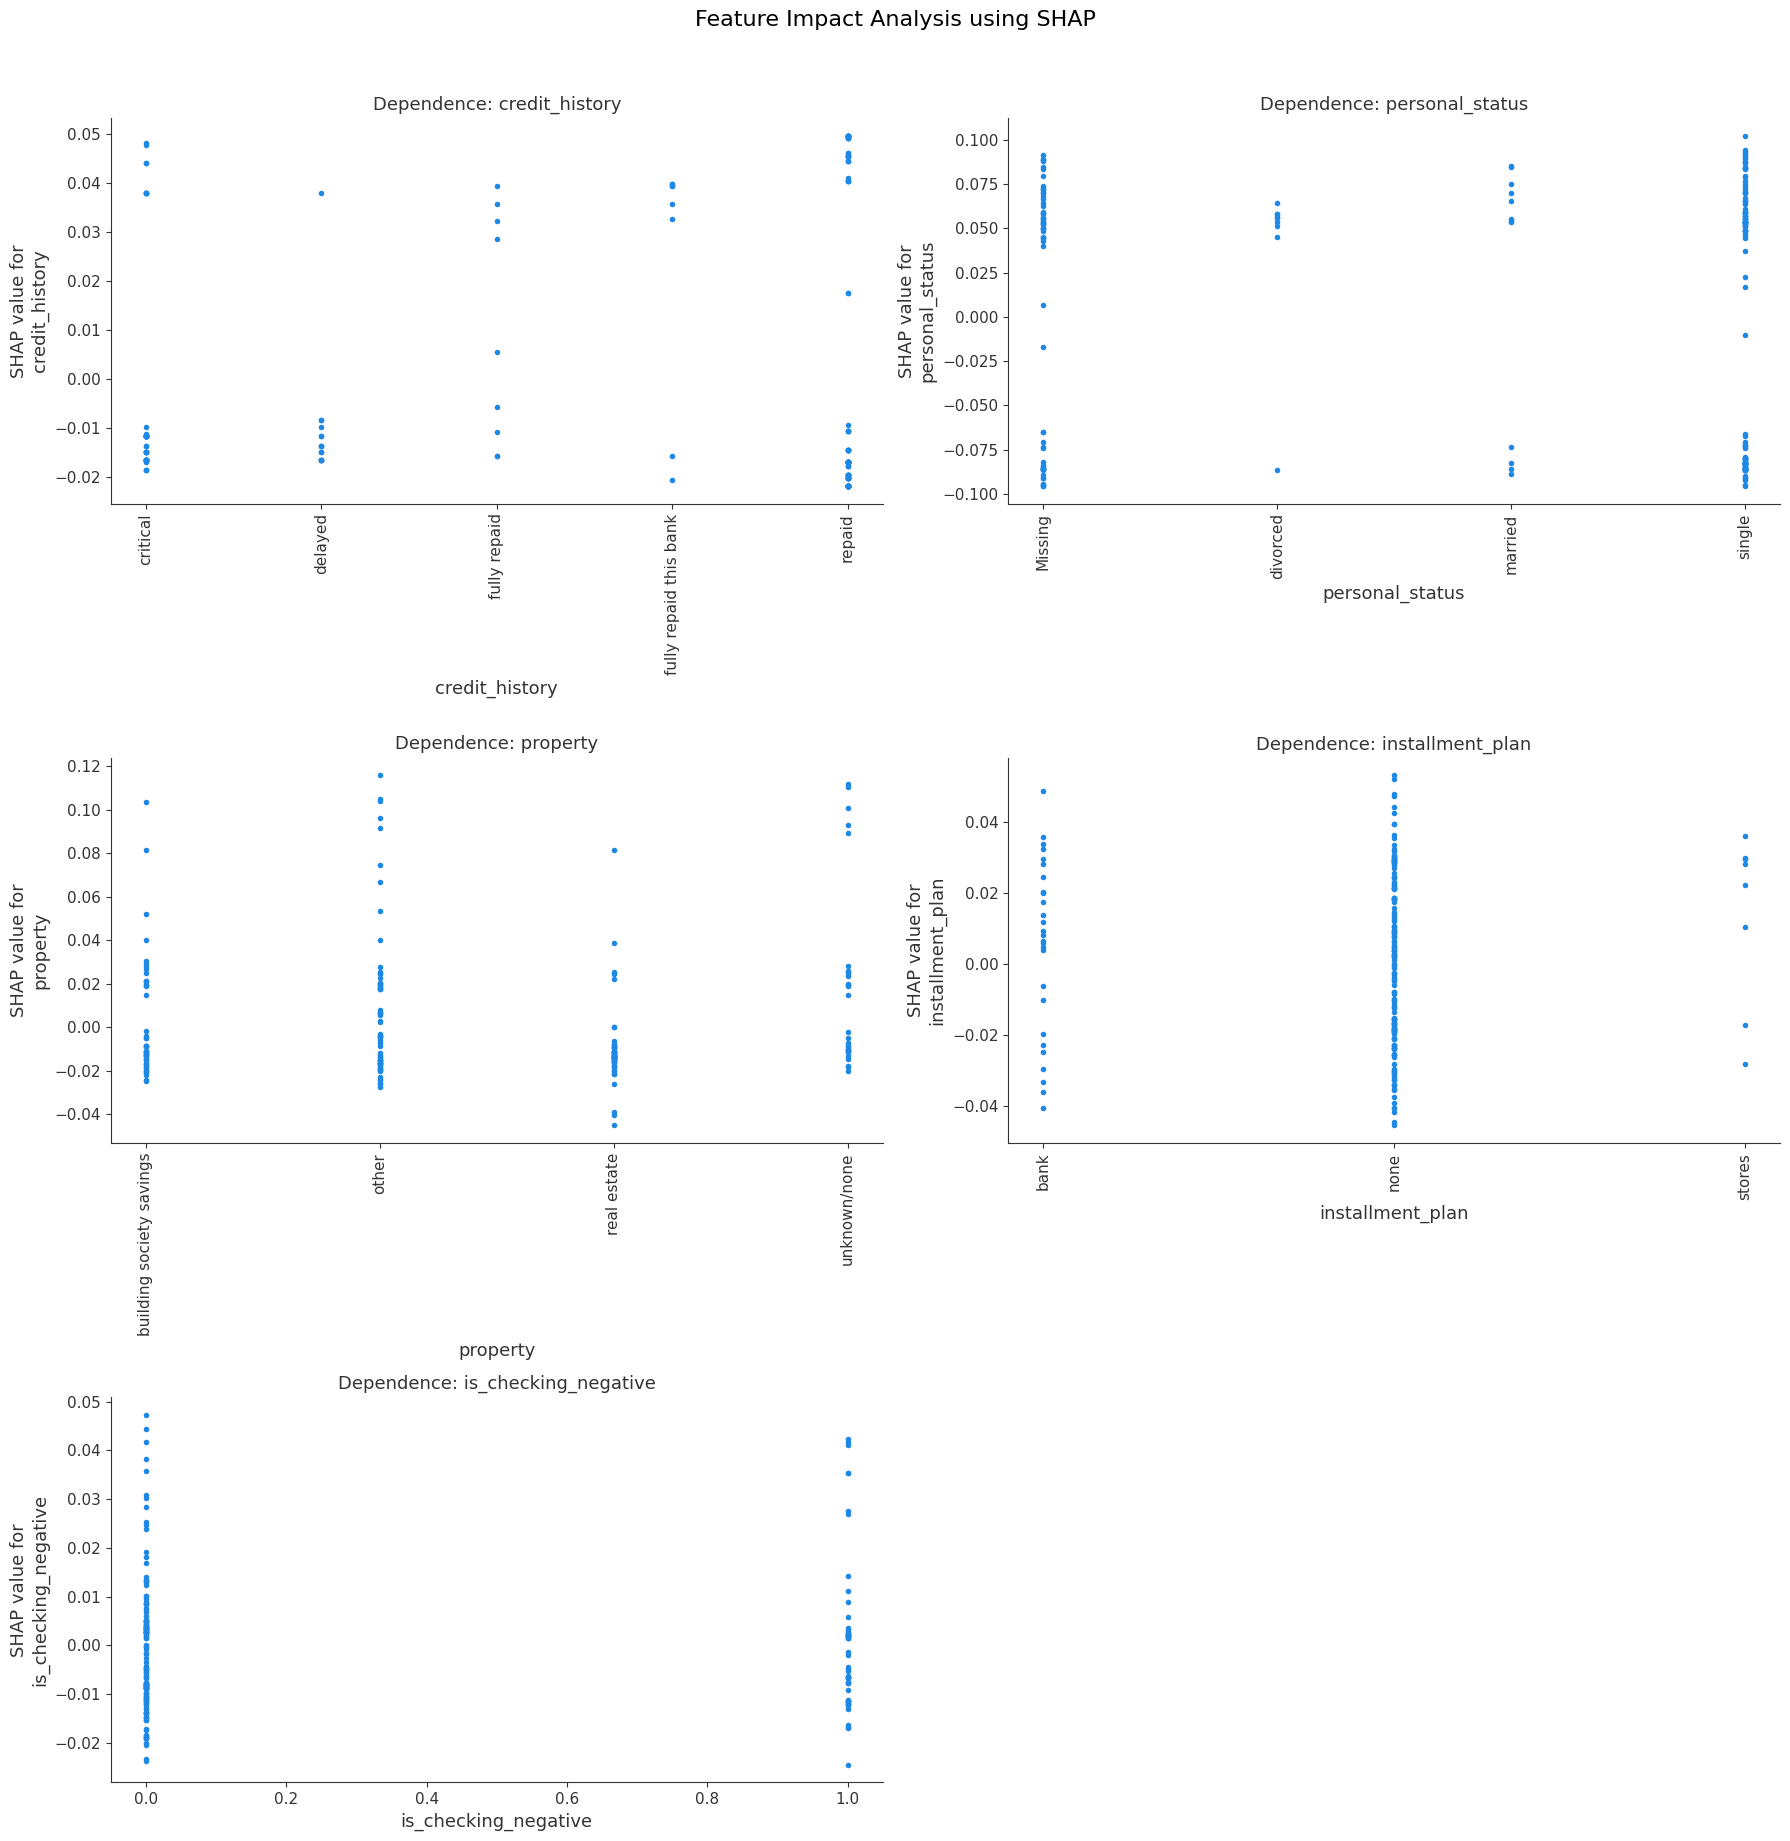

In [10]:
shap_values_cat = shap_values[:, len(feat_num_cat) :]

plot_shap_dependence_grid(
    feature_list=feat_cat_cat,
    shap_values=shap_values_cat,
    X_test=df_test[feat_cat_cat],
    feature_names=feat_cat_cat,
    is_categorical=True,
)

#### Comments:
SHAP global plots confirm the categorical feature patterns identified in EDA.

## Prediction Analysis by Outcome Category

Analyze model behavior across different prediction outcomes to understand strengths and weaknesses.

### True Positives

Examine cases where the model correctly identified booking (actual=1, predicted=1).

In [17]:
# Select top True Positive cases (highest confidence correct default predictions)
df_tp = (
    df_test[(df_test[target] == 1) & (df_test["y_pred"] == 1)]
    .sort_values(by="pred", ascending=False)
    .head(3)
)

print("=== TRUE POSITIVES: Correctly Predicted Defaults ===")
print(
    f"Total True Positives: {len(df_test[(df_test['default'] == 1) & (df_test['y_pred'] == 1)]):,}"
)
print("\nTop 3 highest confidence True Positive predictions:")
df_tp_shap = df_tp[[target, "pred", "y_pred"] + model_cb.feature_names_].head()
df_tp_shap

=== TRUE POSITIVES: Correctly Predicted Defaults ===
Total True Positives: 57

Top 3 highest confidence True Positive predictions:


default      pred  y_pred          credit_history personal_status  \
129        1  0.547785       1  fully repaid this bank        divorced   
63         1  0.546791       1                  repaid          single   
68         1  0.545586       1            fully repaid         Missing   

                     property installment_plan  is_checking_negative  \
129              unknown/none             none                     1   
63                      other             bank                     0   
68   building society savings             bank                     0   

     checking_balance  amount  savings_balance  employment_months  
129             -27.0    2149             49.0                 12  
63               92.0   11328             22.0                 24  
68              135.0   18424             74.0                 24

SHAP explanation for highest confidence True Positive:


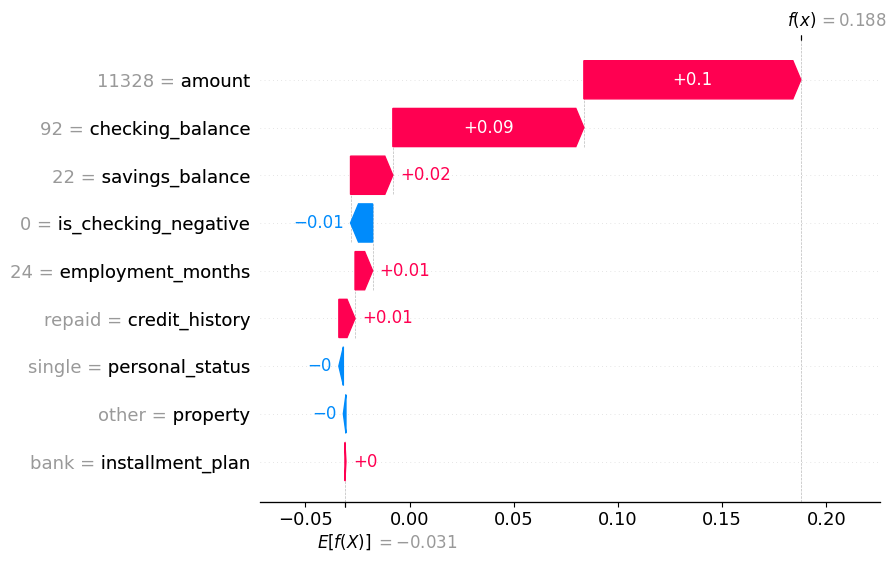

In [12]:
# Convert categorical features to strings for SHAP

# SHAP waterfall plot for first True Positive case
print("SHAP explanation for highest confidence True Positive:")
sv = explainer(df_tp_shap[model_cb.feature_names_])[1]
shap.plots.waterfall(sv, max_display=15)

The model classifies this client as high-risk for the following reasons:
- **High loan amount requested**: The borrower is seeking a substantial loan
- **Low liquidity**: Both checking and savings balances are minimal
- **Risk assessment**: This combination suggests insufficient financial cushion to handle repayment obligations

**Conclusion**: The prediction is reasonable and aligns with fundamental credit risk principles.

### True Negatives

Examine cases where the model correctly identified non-booking (actual=0, predicted=0).

In [ ]:
# Select lowest confidence True Negative cases
df_tn = (
    df_test[(df_test[target] == 0) & (df_test["y_pred"] == 0)]
    .sort_values(by="pred", ascending=True)
    .head(3)
)

print("=== TRUE NEGATIVES: Correctly Predicted Defaults ===")
print(
    f"Total True Negatives: {len(df_test[(df_test[target] == 0) & (df_test['y_pred'] == 0)]):,}"
)
print("\nTop 3 lowest probability True Negative predictions:")
df_tn[[target, "pred", "y_pred"] + feat_num_cat + feat_cat_cat].head()

=== TRUE NEGATIVES: Correctly Predicted Defaults ===
Total True Negatives: 50

Top 3 lowest probability True Negative predictions:


default      pred  y_pred  checking_balance  amount  savings_balance  \
10         0  0.445394       0               NaN    2299            880.0   
194        0  0.447029       0               NaN    2012              NaN   
100        0  0.447217       0               NaN    3578              NaN   

     employment_months credit_history personal_status     property  \
10                 204         repaid          single        other   
194                 84       critical         Missing        other   
100                132       critical          single  real estate   

    installment_plan  is_checking_negative  
10              none                     0  
194             none                     0  
100             none                     0

SHAP explanation for lowest probability True Negative:


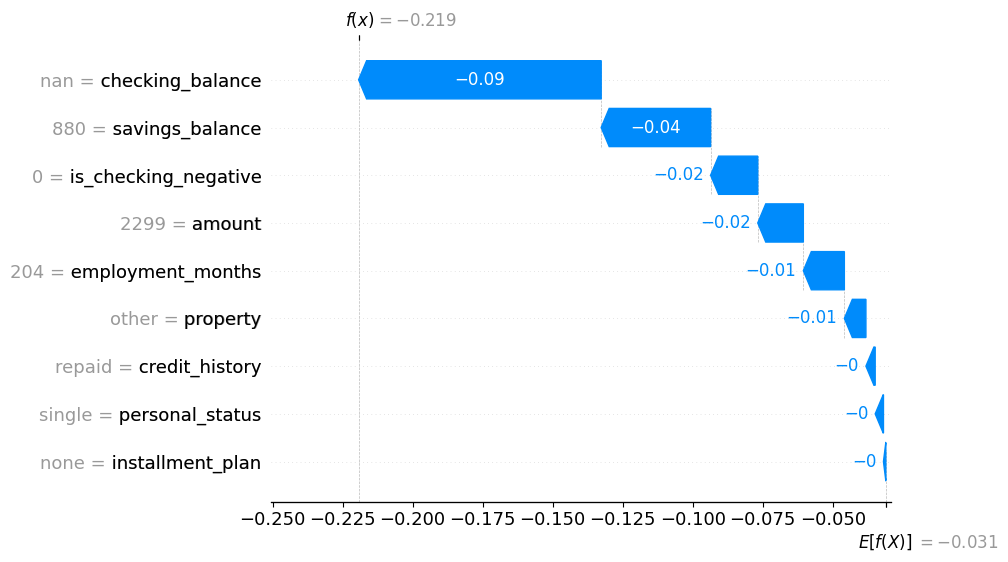

In [16]:
# SHAP waterfall plot for first True Negative case
print("SHAP explanation for lowest probability True Negative:")
sv = explainer(df_tn[model_cb.feature_names_])[0]
shap.plots.waterfall(sv, max_display=15)

The model predicts this client will not default on the loan for the following reasons:

**Supporting factors:**
- **Moderate loan amount**: The borrower is requesting a reasonable loan amount
- **Long employment history**: Extended employment duration indicates stability
- **Adequate savings**: The client maintains an acceptable savings balance

**Contradictory factor:**
- **Empty checking balance**: Despite other positive indicators, the checking account is empty, which typically should signal higher risk

**Conclusion**: While most features support a non-default prediction, the empty checking balance is counterintuitive

### False Positives

In [ ]:
# Select highest confidence False Positive cases
df_fp = (
    df_test[(df_test[target] == 0) & (df_test["y_pred"] == 1)]
    .sort_values(by="pred", ascending=False)
    .head(3)
)

print("=== FALSE POSITIVES: Incorrectly Predicted Defaults ===")
print(
    f"Total False Positives: {len(df_test[(df_test[target] == 0) & (df_test['y_pred'] == 1)]):,}"
)
df_fp[[target, "pred", "y_pred"] + model_cb.feature_names_].head()

=== FALSE POSITIVES: Incorrectly Predicted Defaults ===
Total False Positives: 90


default      pred  y_pred credit_history personal_status  \
3          0  0.541882       1   fully repaid          single   
132        0  0.539177       1        delayed          single   
52         0  0.538151       1       critical          single   

                     property installment_plan  is_checking_negative  \
3    building society savings             bank                     1   
132              unknown/none             none                     0   
52               unknown/none             none                     1   

     checking_balance  amount  savings_balance  employment_months  
3                -8.0    3104             81.0                 84  
132             126.0   11760            148.0                 84  
52              -44.0    6615             52.0                  0

SHAP explanation for highest confidence False Positive:


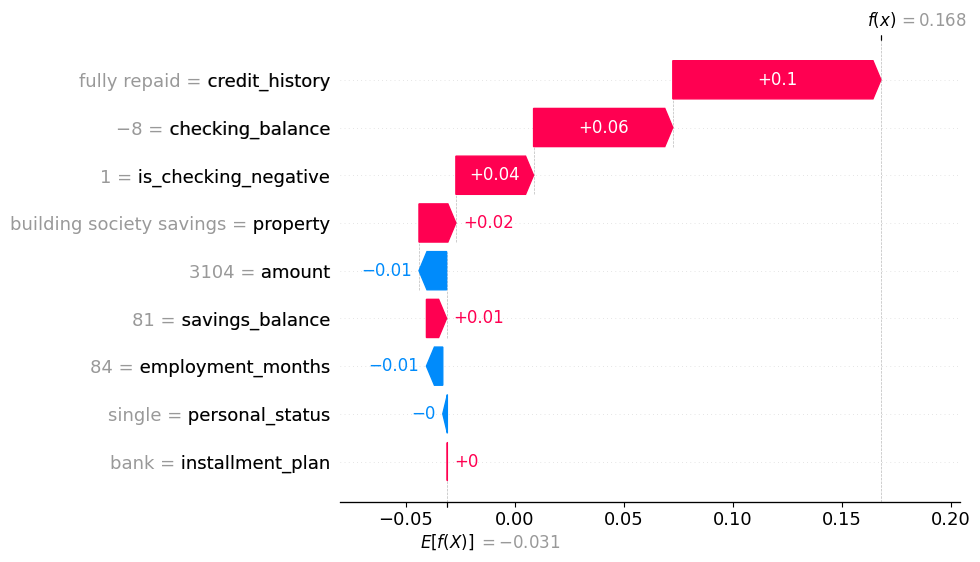

In [36]:
# SHAP waterfall plot for first False Positive case (if available)
print("SHAP explanation for highest confidence False Positive:")
sv = explainer(df_fp[model_cb.feature_names_])[0]
shap.plots.waterfall(sv, max_display=10)

### False Negatives

In [ ]:
df_fn = (
    df_test[(df_test[target] == 1) & (df_test["y_pred"] == 0)]
    .sort_values(by="pred", ascending=True)
    .head(3)
)

print("=== FALSE NEGATIVES: Missed Defaults ===")
print(
    f"Total False Negatives: {len(df_test[(df_test[target] == 1) & (df_test['y_pred'] == 0)]):,}"
)
df_fn[[target, "pred", "y_pred"] + model_cb.feature_names_].head()

=== FALSE NEGATIVES: Missed Defaults ===
Total False Negatives: 3


default      pred  y_pred credit_history personal_status  \
77         1  0.450211       0         repaid          single   
64         1  0.452588       0         repaid         Missing   
109        1  0.460977       0       critical          single   

                     property installment_plan  is_checking_negative  \
77                      other             none                     0   
64   building society savings             none                     0   
109  building society savings             bank                     0   

     checking_balance  amount  savings_balance  employment_months  
77                NaN    1478             78.0                 84  
64                NaN    1386            730.0                 36  
109               NaN    2775             13.0                 48

SHAP explanation for lowest probability False Negative:


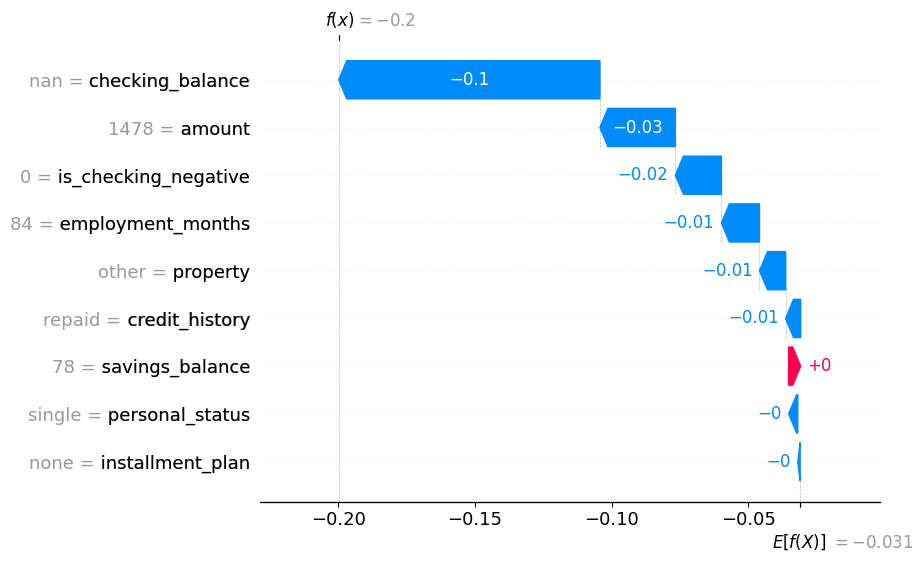

In [38]:
# SHAP waterfall plot for first False Negative case (if available)
print("SHAP explanation for lowest probability False Negative:")
sv = explainer(df_fn[model_cb.feature_names_])[0]
shap.plots.waterfall(sv, max_display=10)